# Object Detector Demo

After frames are retrieved from the dataset (`utils.dataset.aircraft_camera_data`), planes in said frame can be detected using pretrained YOLOv7 model and the AutoSegmentation process. This notebook will demonstrate the high-level usage of this object detection process.

AutoSegmentation process is needed for detecting small object in high-resolution images since pretrained YOLOv7 is trained on 640x640x3 images.

Frames received must be in a resolution of **(*n* x 640, *m* x 640)** in this case, in this case *n* = 2, *m* = 3 (hence  1280, 1920 size)

In [1]:
from utils.dataset import aircraft_camera_data
from utils.weather_modification import *
import utils.object_detector as od
import matplotlib.pyplot as plt
import torch

aircraft-detection custom utils


In [2]:
t = 1 # Time - 5
w = 5 # Weather - 5
r = 1 # Runs - 3

data_indexes = [1,2] # Camera 1 & 2
touchdown_target_lat_lon = [1.3541354199301814, 103.97961848373048] # WSSS 02L Runway
dataset_directory = "/media/gabriel/DATA/dataset"
data_sources = [[f'{dataset_directory}/t{t}/r{r}/w{w}/{data_index}/data.pkl', f'{dataset_directory}/t{t}/r{r}/w{w}/{data_index}/video.avi'] for data_index in data_indexes]

# Dataset Class Initialization
acd = aircraft_camera_data(data_sources = data_sources, touchdown_target_lat_lon = touchdown_target_lat_lon)

In [3]:
# Main Object Detector
mod = od.main_object_detector()

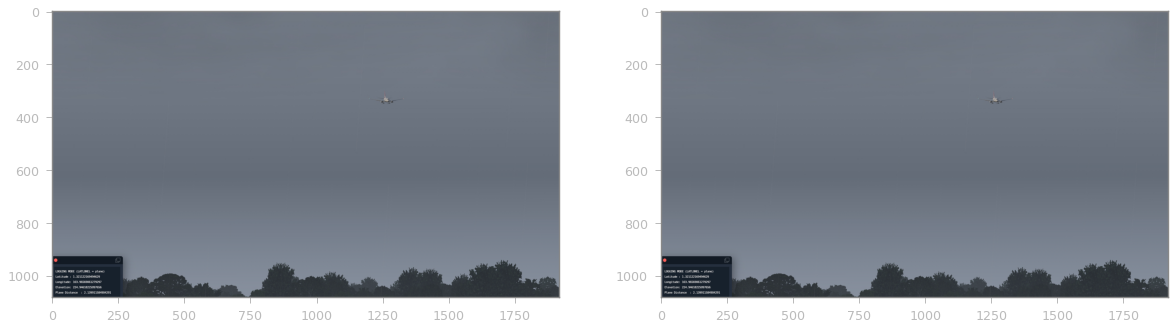

In [4]:
# Getting Frame from Video
n = 4500
img = acd.get_frame_from_video(n, size = (1080, 1920), batch_size = 1)[0].numpy()

# Plotting the Image
fig, ax = plt.subplots(1, 2, figsize = (20,20))
ax[0].imshow(img[0])
ax[1].imshow(img[0])

AutoSegmentation : 0.5516266822814941
Final Inference  : 0.006972074508666992
Post Processing  : 0.0004734992980957031


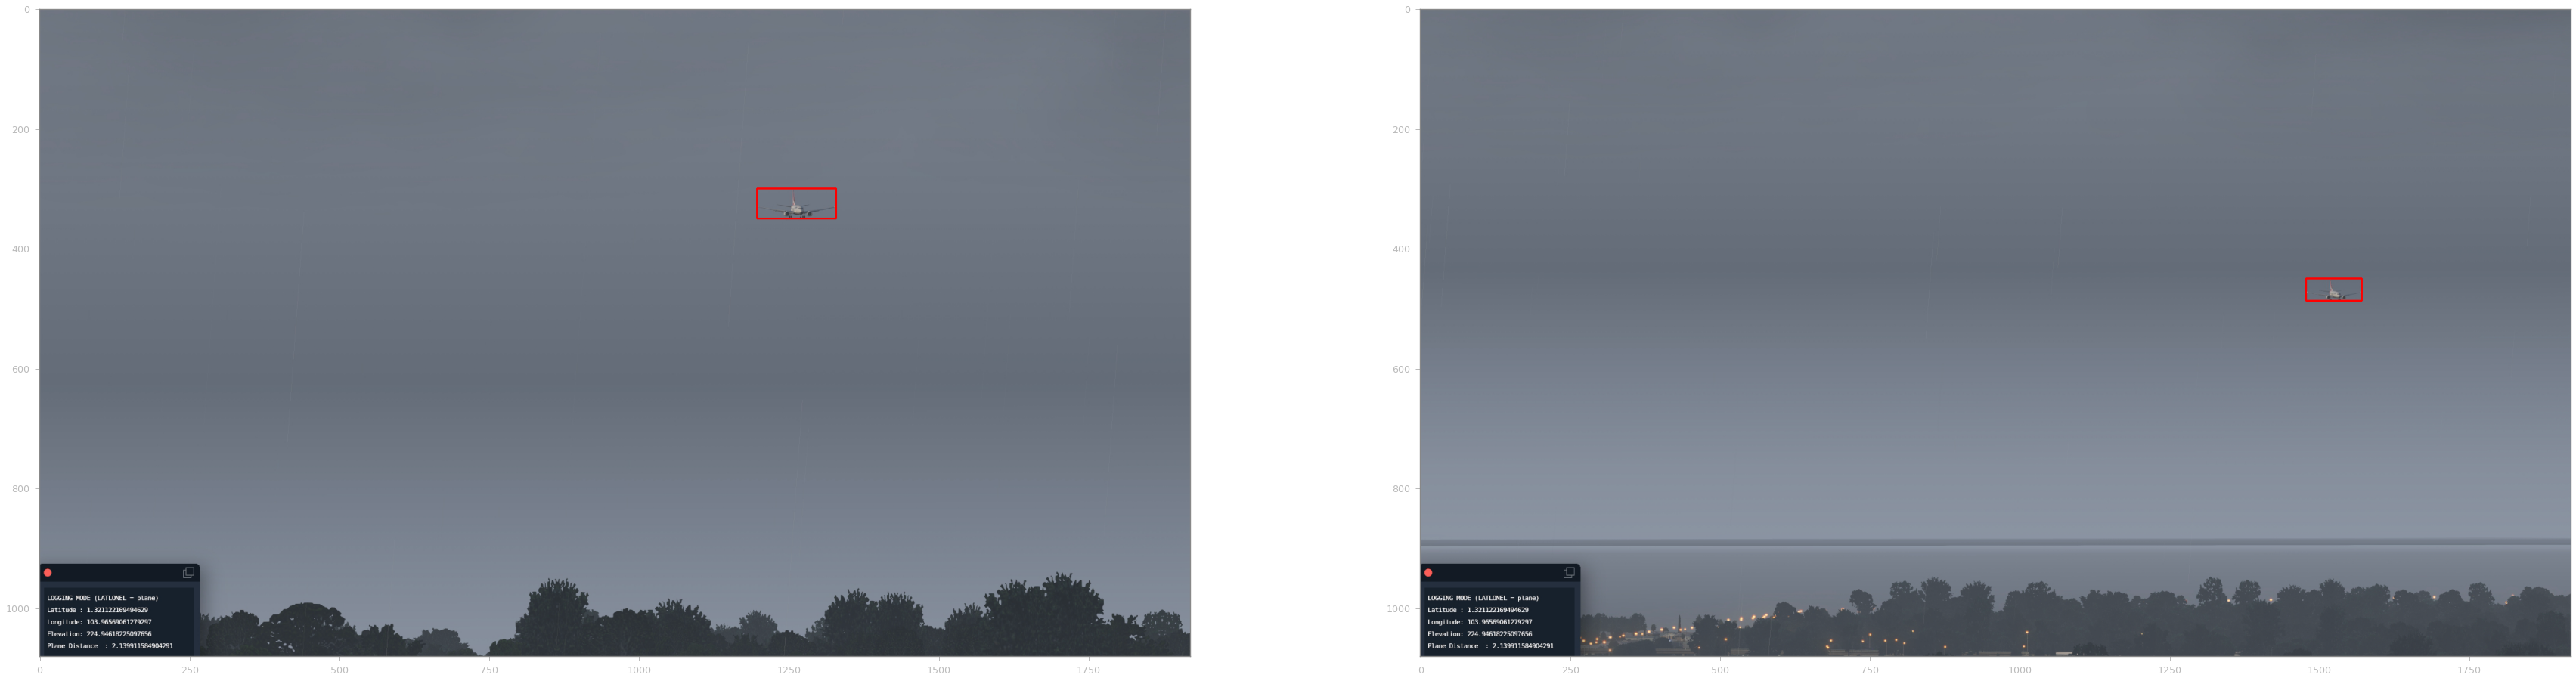

In [5]:
# Getting Frame from Video
n = 4500 # Change This
img = acd.get_frame_from_video(n, size = (1280, 1920), batch_size = 1)

# Inferencing using optimized YOLO
box, score = mod.single_infer(img)

fig, ax = plt.subplots(1, 2,figsize = (60,60))
fig, ax = mod.vis(img[:, :, :1080], box, fig, ax)

AutoSegmentation : 0.047182559967041016
Final Inference  : 0.006898164749145508
Post Processing  : 0.0001289844512939453


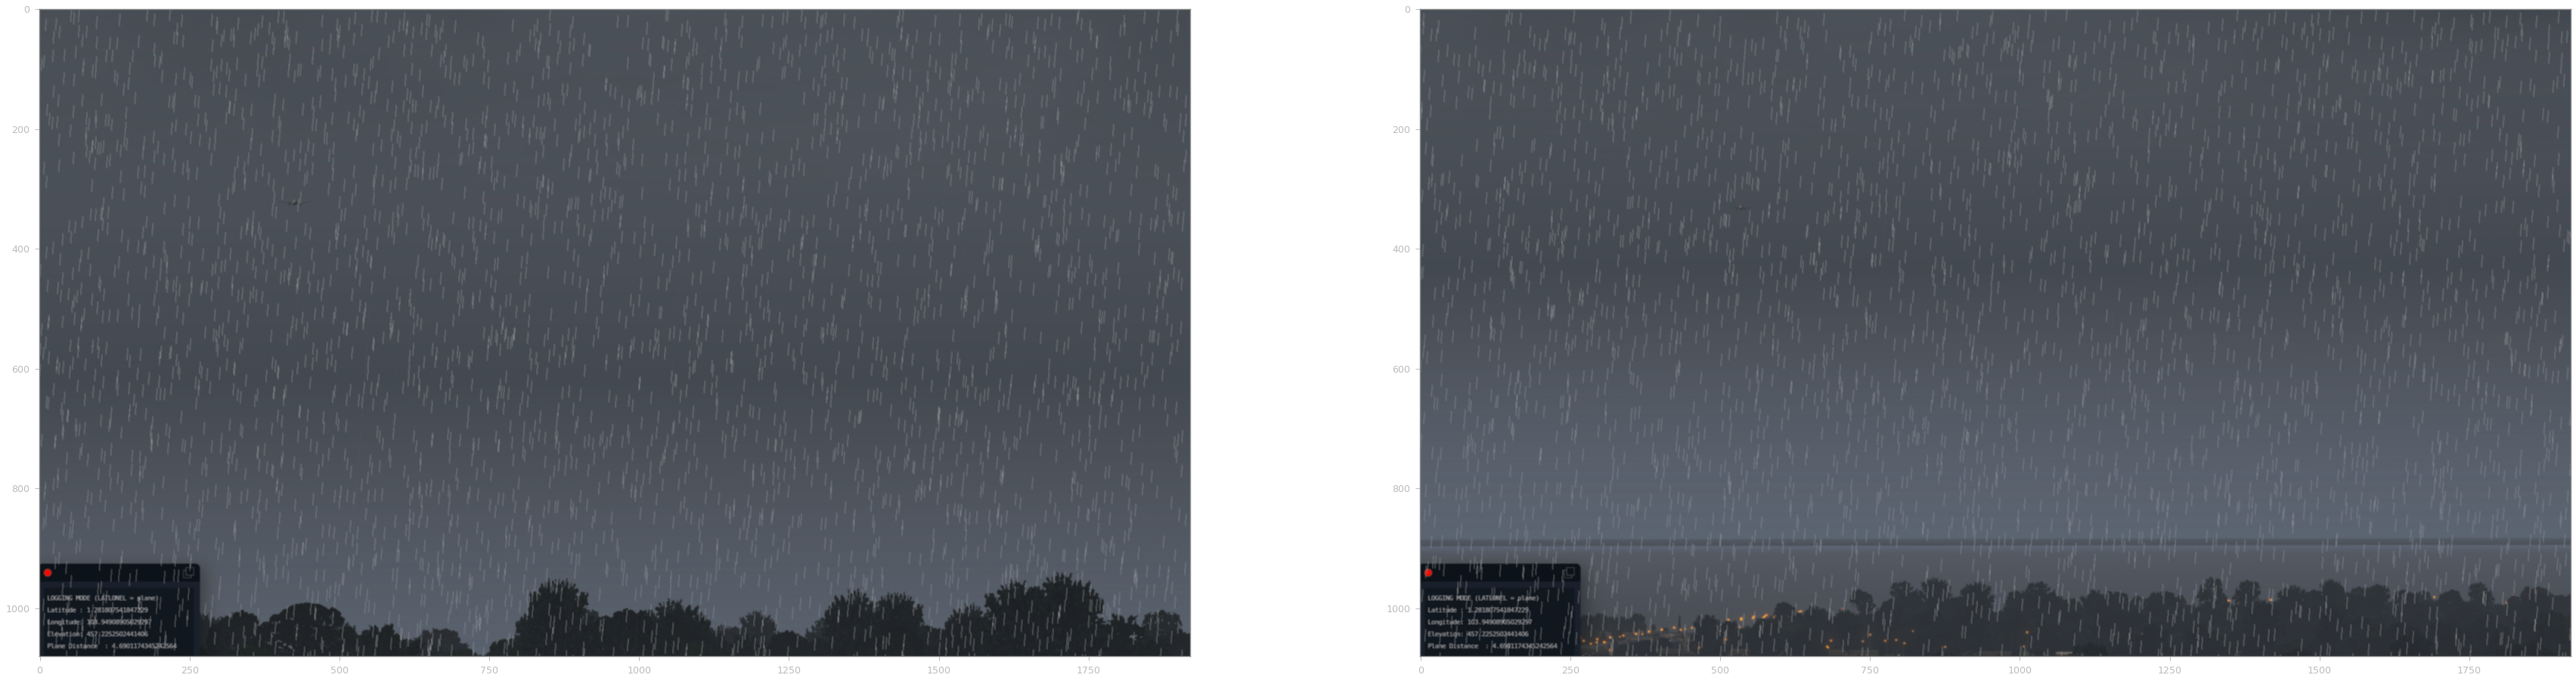

In [6]:
# Adding Weather Condition (Optional)
n = 3000 # Change This
img = acd.get_frame_from_video(n, size = (1280, 1920), batch_size = 1)

img[0, 0] = torch.tensor(add_rain(img[0, 0].numpy(), drop_color=(0.78, 0.78, 0.78)))
img[0, 1] = torch.tensor(add_rain(img[0, 1].numpy(), drop_color=(0.78, 0.78, 0.78)))

box, score = mod.single_infer(img)

fig, ax = plt.subplots(1, 2,figsize = (60,60))
fig, ax = mod.vis(img[:, :, :1080], box, fig, ax)

# Detecting All Frames in a video

All Frames can be detected using `main_object_detector.all_inferece()` method. 

Note that This process might take a while to complete.

In [7]:
box, scores = mod.all_inference(acd)
gt_distance = acd.compute_dtt()
filename = f"output/object_detector/t{t}r{r}w{w}.pkl"
os.makedirs(os.path.dirname(filename), exist_ok=True)
with open(filename, 'wb') as f:
    pkl.dump((box, scores, gt_distance), f)

100%|███████████████████████████████████████| 1003/1003 [18:05<00:00,  1.08s/it]


  0%|          | 0/6016 [00:00<?, ?it/s]

NameError: name 'pkl' is not defined